# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [2]:
# PART 1: PROBABILITY OF POSITIVE BEING TRUE

def nicepct(x):
  return f"{round(x * 100, 1)}%"

def bayesy(probA, probBA, probBnA):
  '''Calculate P(A|B) from P(A), P(B|A), and P(B|A̅)'''
  probnA = 1 - probA
  num = probBA * probA
  denL = num
  denR = probBnA * probnA
  return num / (denL + denR)

def prob_drunk_given_positive(prior, tpos, fpos):
  # In this case, A is "drunk" and B is "tested positive"
  # "BnA" (or "B given not-A") is false positive rate
  return bayesy(prior, tpos, fpos)

def niceprob(a, b, c):
  print("Probability that a positive is true:")
  print(f"\t{nicepct(prob_drunk_given_positive(a, b, c))}")
  print("")

# Sanity Checks
niceprob(0.005, 0.99, 0.01)
niceprob(0.005, 1, 0.01)
print("---\n")

true_pos = 1
false_pos = 0.08
drunk_prior = 0.001
niceprob(drunk_prior, true_pos, false_pos)

Probability that a positive is true:
	33.2%

Probability that a positive is true:
	33.4%

---

Probability that a positive is true:
	1.2%



# What does it mean to run a test twice?

Our confidence in running the test once was a measly 1.2%. We would like more confidence in the positive result, so we decide to run the breathalyzer test a second time when the first result is positive.

What probabilities do we use for the second test?

We have a different `B` this time. Previously it was the possibility of showing up as a positive, but now it's *showing up positive twice*. `P(B|A)` becomes the probability of testing positive two times in a row given that the driver is drunk, and `P(B|A̅)` becomes the probability of testing positive twice, given that the driver is sober.

If you are drunk, then your chances of testing positive are 1; so the probability testing positive *twice* given that you're drunk is still just 1. Sobriety works similarly: If you have an 8% chance of testing positive once, then you'll have a 0.6% of doing it twice (`8/100 * 8/100`)

In our particular case, the only number that changes with each successive test is the rate of false positives; for the nth test use the base prior, the base true positive rate, and then `0.08 ^ n` for  false positive rate

In [3]:
# Now assume you got a positive result TWICE;
# what are the chances they're both true?

new_false_pos = false_pos * false_pos
niceprob(drunk_prior, true_pos, new_false_pos)

Probability that a positive is true:
	13.5%



In [4]:
# How many positive tests would we need in a row for a probability
# of 95% that the driver is actually drunk?

def bayesian_loop(a, ba, bna, threshold=0.95):
  
  # track the "current" P(B|A) and P(B|A̅)
  c_ba = ba
  c_bna = bna
  
  # initialize the loop
  res = prob_drunk_given_positive(a, ba, bna)
  count = 1
  
  # perform successive bayesian calc's until result is above threshold
  # DO NOT use the previous posterior as the current prior
  while res < threshold:
    c_ba *= ba
    c_bna *= bna
    res = prob_drunk_given_positive(a, c_ba, c_bna)
    count += 1
  return (count, nicepct(res))

bayesian_loop(0.001, 1, 0.08)

(4, '96.1%')

In [6]:
# PART 2: EXPLORE BAYES_MVS

import pandas as pd
from scipy import stats
import numpy as np

# forest fires!
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
df = pd.read_csv(data_url)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [7]:
# bayesian mean

m, v, s = stats.bayes_mvs(df['temp'])
bm = (m.minmax[0], m.statistic, m.minmax[1])
bm

(18.46835813696256, 18.88916827852998, 19.309978420097398)

In [8]:
# frequentist mean

def confidence_interval(data, confidence=.95):
  n = len(data)
  mean = sum(data)/n
  data = np.array(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n-1)
  return (mean - interval, mean, mean + interval)

fm = confidence_interval(df['temp'], 0.9)
fm

(18.46835813696256, 18.88916827852998, 19.309978420097398)

In [0]:
# everything is the same :/

for i in range(3):
  assert(bm[i] == fm[i])

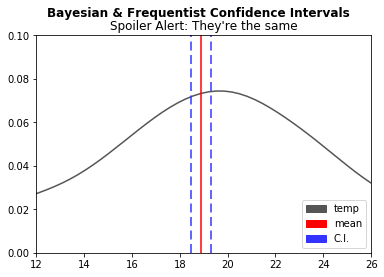

In [12]:
# graph mean & confidence interval

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# color palette
bla = '#555555'
blu = '#3333ff'
red = '#ff0000'

# density plot of the temperatures recorded,
# as well as a line for the mean of the data
sns.kdeplot(df['temp'], color=bla)
plt.axvline(bm[1], color=red)

# pretty lines for the confidence intervals
ds1 = (6,3)
plt.axvline(bm[0], color=blu, dashes=ds1)
plt.axvline(bm[2], color=blu, dashes=ds1)

# include all of our colors on the legend
temp = mpatches.Patch(color=bla, label='temp')
truem = mpatches.Patch(color=red, label='mean')
conf = mpatches.Patch(color=blu, label='C.I.')
plt.legend(handles=[temp, truem, conf], loc='lower right')

# tidy up graph details
plt.xlim(12,26)
plt.ylim(0,0.1)
plt.suptitle('Bayesian & Frequentist Confidence Intervals', fontweight='bold')
plt.title('Spoiler Alert: They\'re the same')

# et voila!
plt.show()

# What is the difference between the Bayesian and Frequentist statistics?

In my words, frequentist statistics is the set theoretical approach, whereas Bayesian statistics is the prejudicial approach.

Frequentism speaks of possibilities in terms of *how many* there are, which are equivalent to which; it speaks of an abstract "event space" that gets partitioned into "possible outcomes".

Bayesians, on the other hand, frame everything in terms of their own priors. Given what we know about reality (or the Apocalypse, or gambling, or ...), it is just way more freaking likely that two sixes were rolled than that the sun actually exploded. "Given what we know" is the explicit confirmation that we are assuming our axioms to be true, our explicit confirmation that we're going to let our own, personal "anecdotal evidence" hold sway. (That these priors may [or may not] be updated as new experiences are acquired doesn't alter this analysis in any way.)

While the Bayesian says, "I'll believe it when I see it," the frequentist says, "It is (in a strict, mathematical sense) false to say that 'it' cannot be seen at all."

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!